In [147]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist, pdist

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [4]:
data = pd.read_csv('data/economic_freedom_index2019_data.csv')
data.shape

(186, 34)

In [7]:
data.sample(10, random_state=1)

,CountryID,Country Name,WEBNAME,Region,World Rank,Region Rank,2019 Score,Property Rights,Judical Effectiveness,Government Integrity,...,Country,Population (Millions),"GDP (Billions, PPP)",GDP Growth Rate (%),5 Year GDP Growth Rate (%),GDP per Capita (PPP),Unemployment (%),Inflation (%),FDI Inflow (Millions),Public Debt (% of GDP)
16,17,Benin,Benin,Sub-Saharan Africa,127.0,21.0,55.3,37.2,32.8,28.1,...,Benin,11.1,$25.3,5.6,5.0,"$2,277",2.5,0.1,184.4,54.6
180,178,Vanuatu,Vanuatu,Asia-Pacific,116.0,26.0,56.4,65.9,36.4,51.9,...,Vanuatu,0.3,$0.8,4.2,2.4,"$2,739",5.2,3.1,24.7,48.4
66,65,Guatemala,Guatemala,Americas,77.0,16.0,62.6,40.3,32.3,26.4,...,Guatemala,16.9,$137.8,2.8,3.6,"$8,145",2.7,4.4,"1,146.7",24.4
40,40,C�te d'Ivoire,CoeDivoire,Sub-Saharan Africa,78.0,5.0,62.4,40.9,47.8,38.1,...,C�te d'Ivoire,25.0,$96.9,7.8,8.6,"$3,883",2.6,0.8,674.7,46.4
167,165,Togo,Togo,Sub-Saharan Africa,158.0,35.0,50.3,35.5,29.6,28.1,...,Togo,7.8,$12.9,4.4,5.5,"$1,659",1.8,-0.7,145.6,78.6
170,168,Tunisia,Tunisia,Middle East and North Africa,125.0,10.0,55.4,49.2,42.7,36.6,...,Tunisia,11.5,$135.4,1.9,1.7,"$11,755",15.4,5.3,879.5,71.3
97,95,Liberia,Liberia,Sub-Saharan Africa,160.0,37.0,49.7,26.7,39.0,24.2,...,Liberia,4.5,$6.1,2.5,2.1,"$1,354",2.4,12.4,247.8,34.4
130,128,Papua New Guinea,PapuaNewGuinea,Asia-Pacific,101.0,21.0,58.4,37.4,49.0,37.2,...,Papua New Guinea,8.3,$30.3,2.5,5.8,"$3,675",2.7,5.2,-200.5,32.6
35,35,Colombia,Colombia,Americas,49.0,8.0,67.3,59.2,34.3,33.5,...,Colombia,49.3,$714.0,1.8,3.2,"$14,485",8.9,4.3,"14,518.0",49.4
54,54,Estonia,Estonia,Europe,15.0,7.0,76.6,81.5,76.0,73.1,...,Estonia,1.3,$41.6,4.9,2.7,"$31,750",5.8,3.7,784.4,8.8


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CountryID                    186 non-null    int64  
 1   Country Name                 186 non-null    object 
 2   WEBNAME                      186 non-null    object 
 3   Region                       186 non-null    object 
 4   World Rank                   180 non-null    float64
 5   Region Rank                  180 non-null    float64
 6   2019 Score                   180 non-null    float64
 7   Property Rights              185 non-null    float64
 8   Judical Effectiveness        185 non-null    float64
 9   Government Integrity         185 non-null    float64
 10  Tax Burden                   180 non-null    float64
 11  Gov't Spending               183 non-null    float64
 12  Fiscal Health                183 non-null    float64
 13  Business Freedom    

In [51]:
df = data.copy()

In [52]:
df.drop(columns=["CountryID", "Country Name"], inplace=True)

In [83]:
df.dropna(inplace=True)

In [69]:
df["Country"] = df["WEBNAME"]
df.drop("WEBNAME", axis=1, inplace=True)

In [70]:
def clean(x):
    if type(x) == type(2.2):
        return x
    else:
        return float(x.strip().split()[0].replace("$","").replace(",",""))
df["GDP (Billions, PPP)"]=df["GDP (Billions, PPP)"].apply(clean)

In [71]:
df["Population (Millions)"] = df["Population (Millions)"].apply(clean).astype("float")

In [72]:
df["Unemployment (%)"] = df["Unemployment (%)"].apply(clean).astype("float")

In [73]:
df["GDP per Capita (PPP)"] = df["GDP per Capita (PPP)"].apply(clean).astype("float")

In [74]:
df["FDI Inflow (Millions)"] = df["FDI Inflow (Millions)"].apply(clean).astype("float")

In [75]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
World Rank,180.0,90.500000,52.105662,1.0,45.750,90.50,135.250,180.0
Region Rank,180.0,20.538889,12.738611,1.0,9.750,19.50,31.000,47.0
2019 Score,180.0,60.768333,11.255725,5.9,53.950,60.75,67.800,90.2
Property Rights,185.0,52.327568,19.608526,7.6,37.000,50.10,65.900,97.4
Judical Effectiveness,185.0,44.899459,18.104745,5.0,31.000,42.90,54.700,92.4
Government Integrity,185.0,41.470270,19.793193,7.9,27.200,35.50,50.300,96.7
Tax Burden,180.0,77.212778,13.208314,0.0,70.975,78.05,85.425,99.8
Gov't Spending,183.0,64.203825,23.150984,0.0,51.700,68.80,82.600,96.6
Fiscal Health,183.0,65.996721,31.764160,0.0,39.900,80.30,91.450,100.0
Business Freedom,185.0,63.514054,15.799326,5.0,54.100,64.30,75.000,96.4


Governmen Integrity, Inflation, GDP per capita, and Public Debt, and FDI inflow are right-skewed.

In [76]:
df.isna().sum()

Region                         0
World Rank                     6
Region Rank                    6
2019 Score                     6
Property Rights                1
Judical Effectiveness          1
Government Integrity           1
Tax Burden                     6
Gov't Spending                 3
Fiscal Health                  3
Business Freedom               1
Labor Freedom                  2
Monetary Freedom               2
Trade Freedom                  4
Investment Freedom             2
Financial Freedom              5
Tariff Rate (%)                4
Income Tax Rate (%)            3
Corporate Tax Rate (%)         3
Tax Burden % of GDP            7
Gov't Expenditure % of GDP     4
Country                        0
Population (Millions)          0
GDP (Billions, PPP)            1
GDP Growth Rate (%)            2
5 Year GDP Growth Rate (%)     3
GDP per Capita (PPP)           2
Unemployment (%)               5
Inflation (%)                  4
FDI Inflow (Millions)          5
Public Deb

## Univariate Analysis

In [77]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<ipython-input-77-7304159d6931>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f2, (ax_box2, ax_hist2) = plt.subplots(


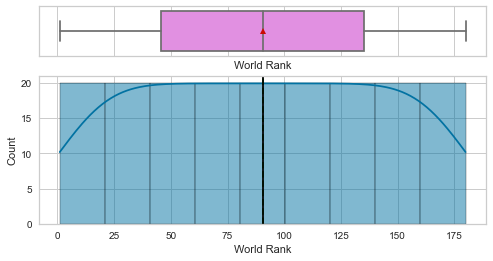

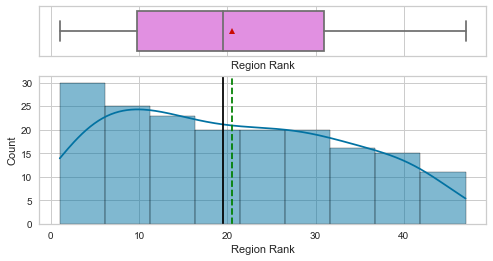

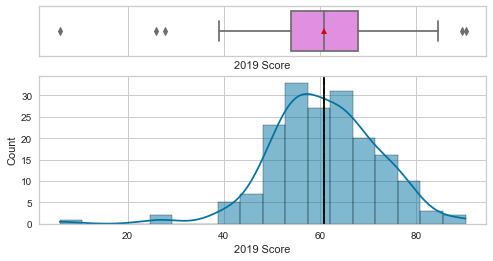

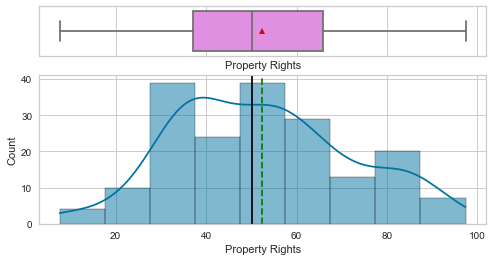

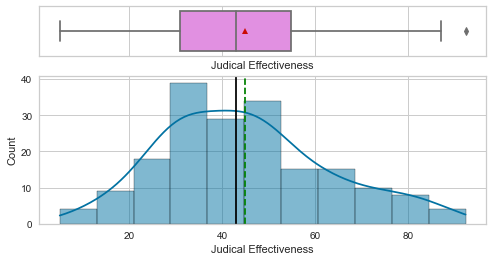

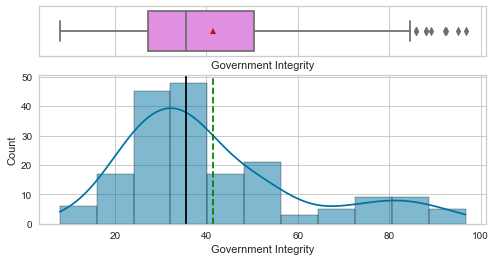

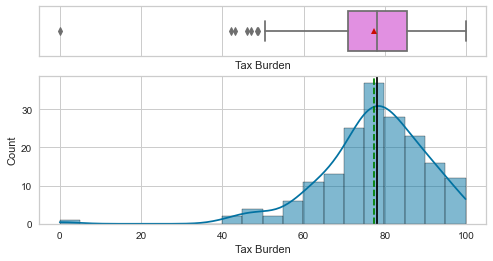

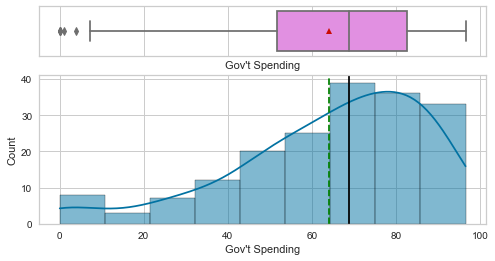

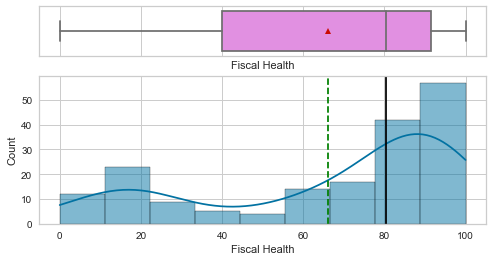

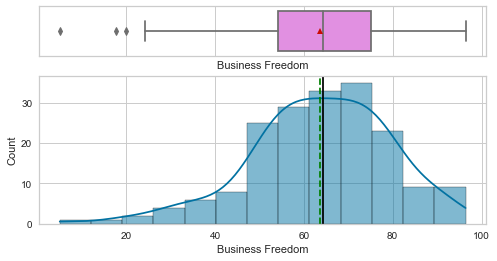

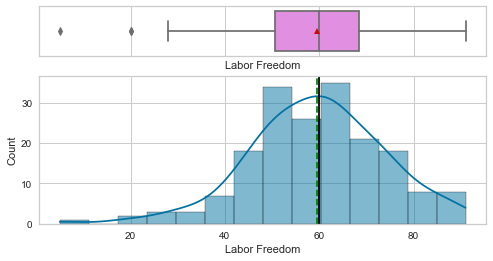

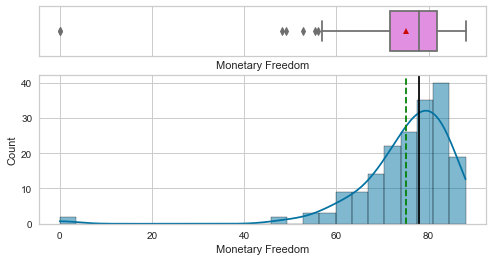

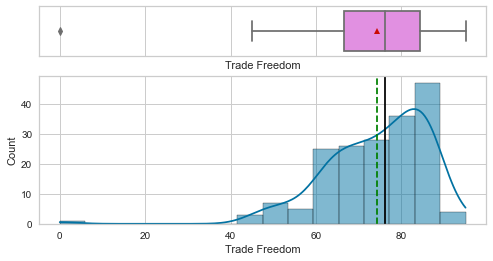

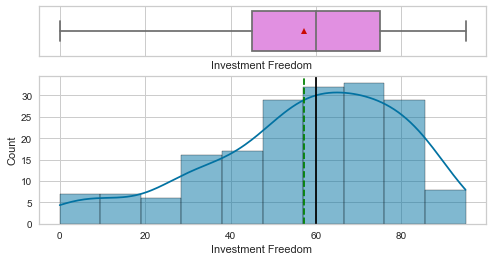

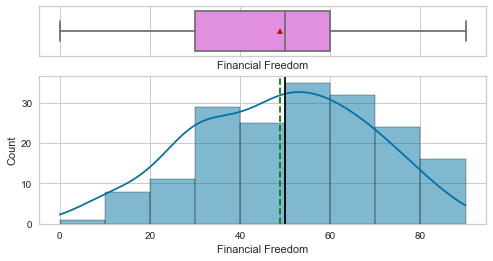

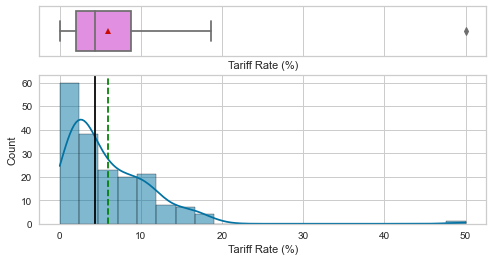

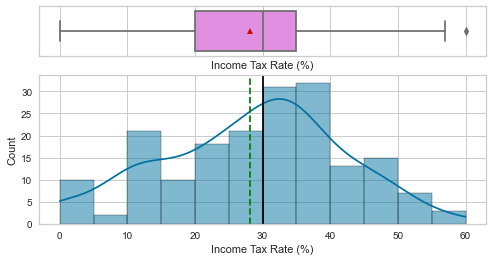

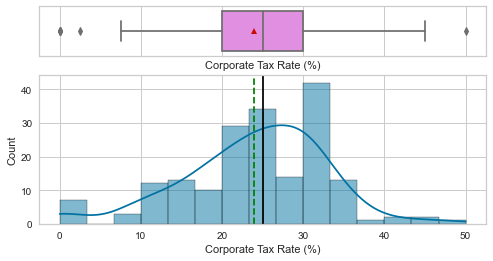

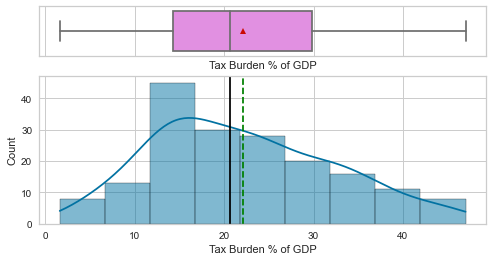

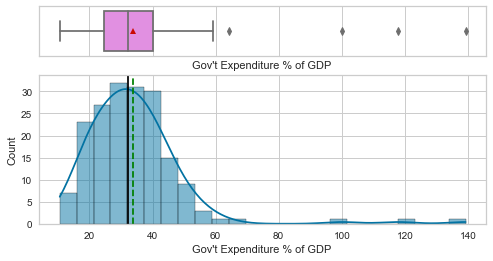

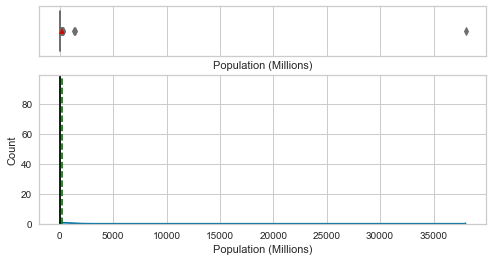

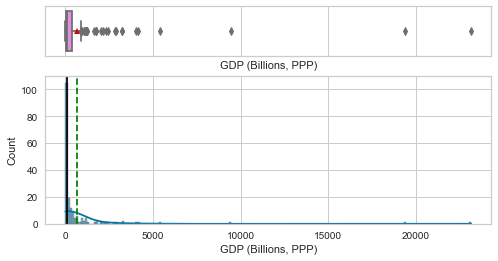

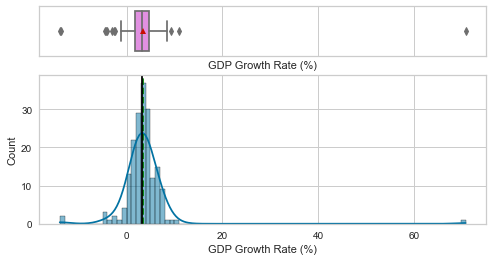

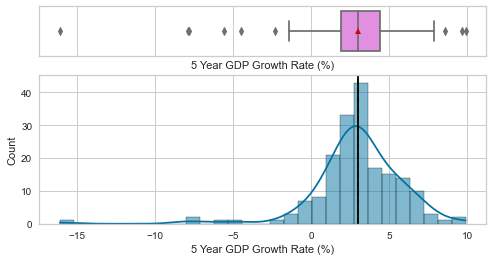

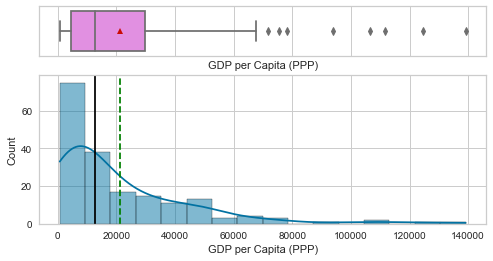

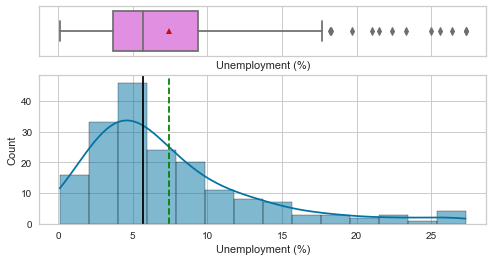

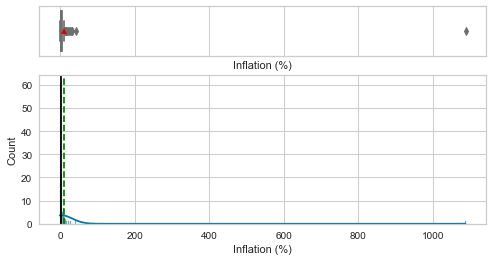

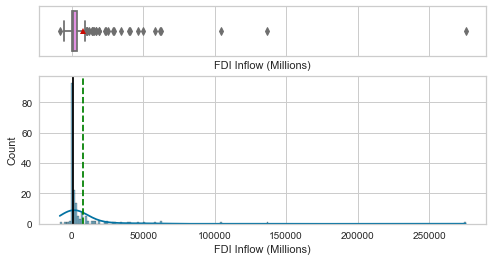

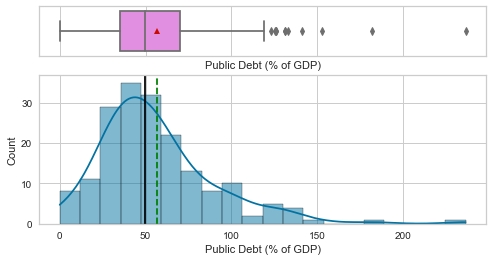

In [78]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item, kde=True, figsize=(8, 4))

In [79]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

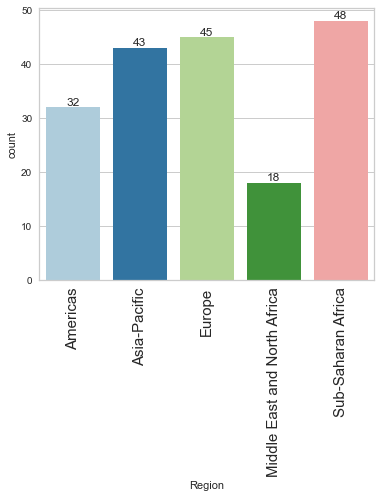

In [81]:
cat_col = np.setdiff1d(df.columns, np.append(num_col, "Country"))
for item in cat_col:
    labeled_barplot(df, item)

## Bivariate Analysis

<AxesSubplot:>

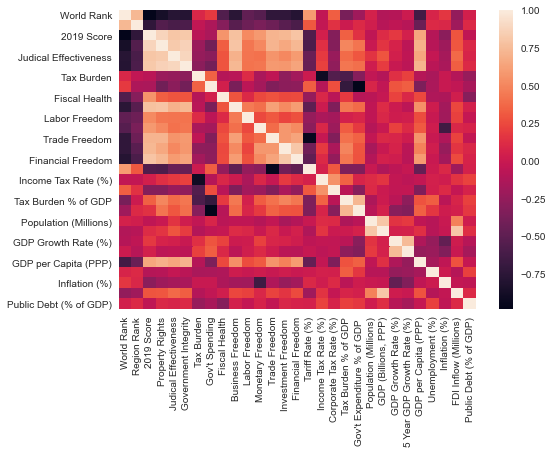

In [84]:
sns.heatmap(df.corr())

In [86]:
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [87]:
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

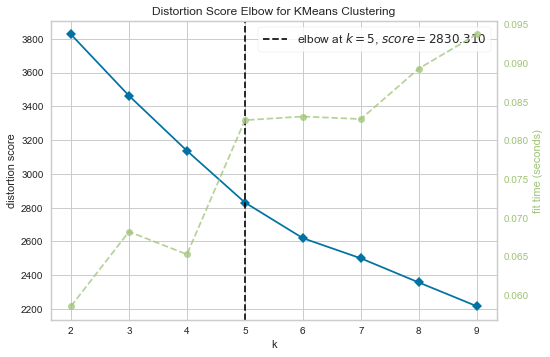

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [140]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 10), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

The elbow is not apparent.

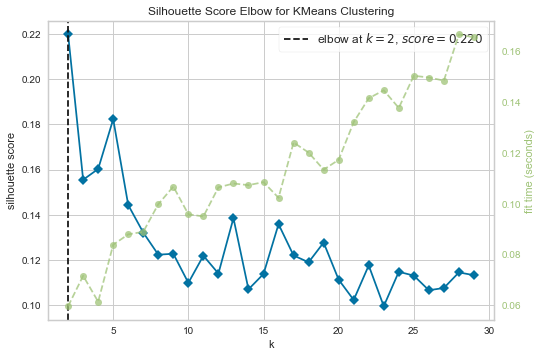

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [142]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 30), metric="silhouette", timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

the appropriate k seems to be 2

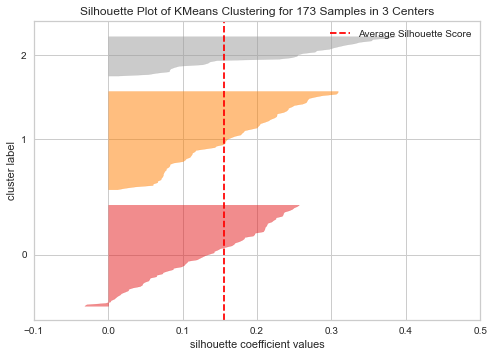

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 173 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [127]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

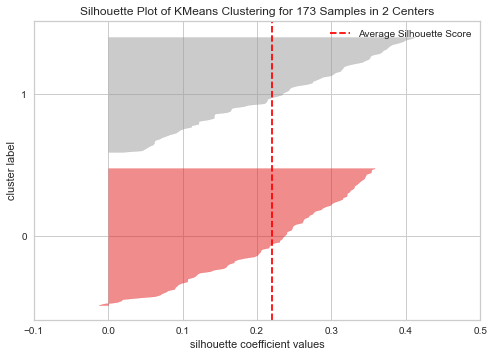

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 173 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [129]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Let's take K = 2, as the silhouette score is much lower for everything else. Also, the distributions look good.

In [130]:
kmeans = KMeans(n_clusters=2, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=2, random_state=1)

In [192]:
df["K_means_segments"] = kmeans.labels_

In [132]:
cluster_profile = df.groupby("K_means_segments").mean()
cluster_profile

,World Rank,Region Rank,2019 Score,Property Rights,Judical Effectiveness,Government Integrity,Tax Burden,Gov't Spending,Fiscal Health,Business Freedom,...,Gov't Expenditure % of GDP,Population (Millions),"GDP (Billions, PPP)",GDP Growth Rate (%),5 Year GDP Growth Rate (%),GDP per Capita (PPP),Unemployment (%),Inflation (%),FDI Inflow (Millions),Public Debt (% of GDP)
K_means_segments,,,,,,,,,,,,,,,,,,,,,
0,128.329787,26.074468,54.020213,40.120213,35.145745,29.713830,79.282979,73.196809,56.920213,55.884043,...,28.378723,59.089362,617.684043,3.504255,3.61383,7893.872340,6.853191,18.048936,4268.818085,53.775532
1,42.303797,13.253165,70.069620,69.555696,59.013924,57.241772,75.825316,57.478481,78.581013,75.239241,...,36.359494,21.867089,861.143038,3.036709,2.64557,37201.227848,7.902532,2.327848,13104.922785,60.107595


## Hierarchical Clustering

In [143]:
hc_df = subset_scaled_df.copy()

In [148]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7671205834477057.
Cophenetic correlation for Euclidean distance and complete linkage is 0.6477247025858096.
Cophenetic correlation for Euclidean distance and average linkage is 0.851332677032837.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.7815840364333343.
Cophenetic correlation for Chebyshev distance and single linkage is 0.745148756223126.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.6999030709286089.
Cophenetic correlation for Chebyshev distance and average linkage is 0.784008102599873.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.7891454295915764.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7603964543188362.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.49931504290016737.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.7452348836461864.
Cophenetic corr

In [149]:
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.851332677032837, which is obtained with Euclidean distance and average linkage.


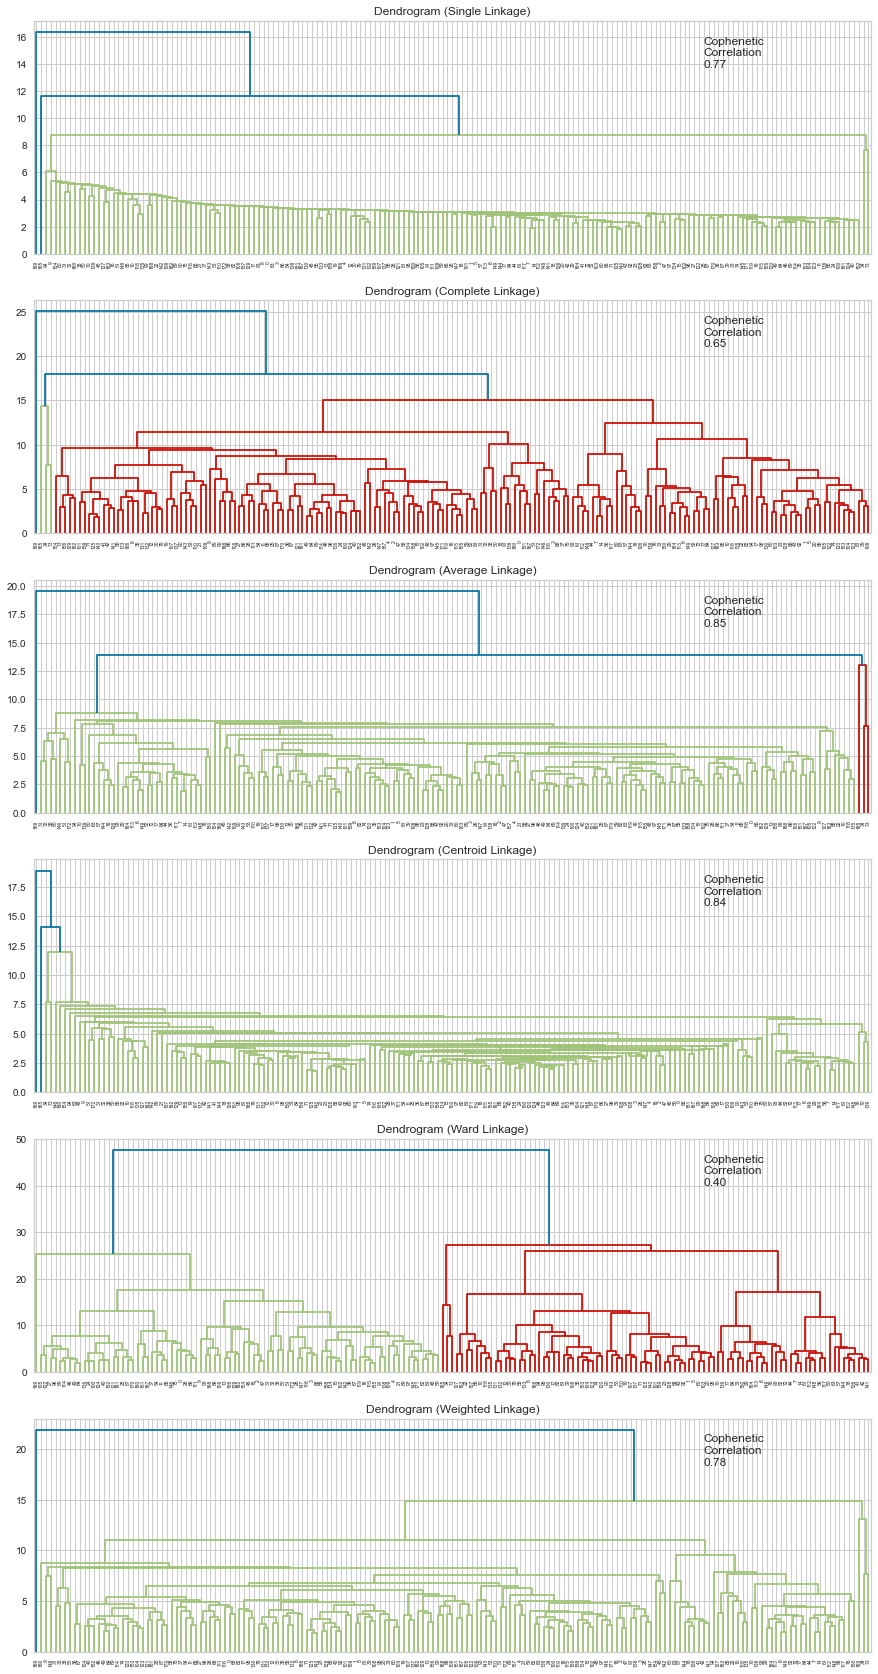

In [155]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

shows two distinct clusters

In [156]:
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
4,ward,0.400874
1,complete,0.647725
0,single,0.767121
5,weighted,0.781584
3,centroid,0.840016
2,average,0.851333


In [157]:
HCmodel = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="average")
HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average')

In [158]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

In [162]:
hc_cluster_profile = df.groupby("HC_Clusters").mean()

## Compare

In [163]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,World Rank,Region Rank,2019 Score,Property Rights,Judical Effectiveness,Government Integrity,Tax Burden,Gov't Spending,Fiscal Health,Business Freedom,Labor Freedom,Monetary Freedom,Trade Freedom,Investment Freedom,Financial Freedom,Tariff Rate (%),Income Tax Rate (%),Corporate Tax Rate (%),Tax Burden % of GDP,Gov't Expenditure % of GDP,Population (Millions),"GDP (Billions, PPP)",GDP Growth Rate (%),5 Year GDP Growth Rate (%),GDP per Capita (PPP),Unemployment (%),Inflation (%),FDI Inflow (Millions),Public Debt (% of GDP)
K_means_segments,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,128.329787,26.074468,54.020213,40.120213,35.145745,29.713830,79.282979,73.196809,56.920213,55.884043,55.543617,71.639362,68.180851,45.212766,37.340426,7.903191,28.230851,26.456383,17.858511,28.378723,59.089362,617.684043,3.504255,3.613830,7893.872340,6.853191,18.048936,4268.818085,53.775532
1,42.303797,13.253165,70.069620,69.555696,59.013924,57.241772,75.825316,57.478481,78.581013,75.239241,65.415190,80.493671,83.163291,74.493671,64.303797,2.911392,29.048101,20.894937,27.027848,36.359494,21.867089,861.143038,3.036709,2.645570,37201.227848,7.902532,2.327848,13104.922785,60.107595


In [165]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,World Rank,Region Rank,2019 Score,Property Rights,Judical Effectiveness,Government Integrity,Tax Burden,Gov't Spending,Fiscal Health,Business Freedom,Labor Freedom,Monetary Freedom,Trade Freedom,Investment Freedom,Financial Freedom,Tariff Rate (%),Income Tax Rate (%),Corporate Tax Rate (%),Tax Burden % of GDP,Gov't Expenditure % of GDP,Population (Millions),"GDP (Billions, PPP)",GDP Growth Rate (%),5 Year GDP Growth Rate (%),GDP per Capita (PPP),Unemployment (%),Inflation (%),FDI Inflow (Millions),Public Debt (% of GDP),K_means_segments
HC_Clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,88.523256,20.151163,61.555233,53.829070,46.236628,42.484302,77.721512,66.065116,67.097674,64.901744,60.237791,76.122674,75.109884,58.924419,49.883721,5.598256,28.572674,23.858140,22.087209,31.991860,42.154070,730.883140,3.391279,3.235465,21330.273256,7.330233,4.610465,8352.475581,56.793605,0.459302
1,179.000000,32.000000,25.900000,7.600000,13.100000,7.900000,74.700000,58.100000,17.600000,33.900000,28.000000,0.000000,60.000000,0.000000,10.000000,10.000000,34.000000,34.000000,14.900000,37.400000,31.400000,380.700000,-14.000000,-7.800000,12114.000000,7.700000,1087.500000,-68.000000,34.900000,0.000000


The categories are flipped.

In [193]:
df.loc[df["K_means_segments"] == 1, "K_means_segments"] = 2
df.loc[df["K_means_segments"] == 0, "K_means_segments"] = 1
df.loc[df["K_means_segments"] == 2, "K_means_segments"] = 0

<AxesSubplot:xlabel='K_means_segments'>

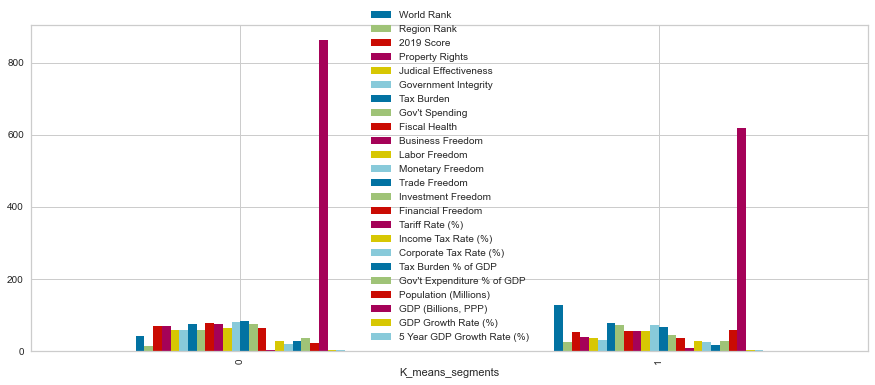

In [196]:
df.groupby("K_means_segments").mean()[num_col[:24]].plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='HC_Clusters'>

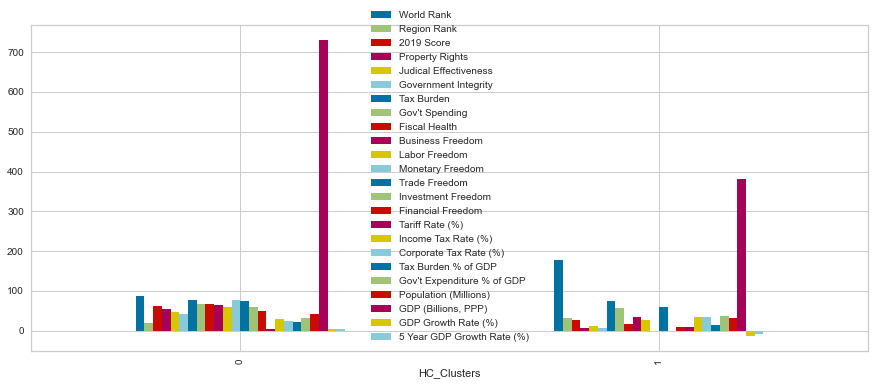

In [187]:
df.groupby("HC_Clusters").mean()[num_col[:24]].plot.bar(figsize=(15, 6))

In both HC and Kmeans, there seems to be a clear difference in World Rank, Region Rank, 2019 score, Property Rights, Government Integrity, Investment Freedom, GDP, and...

<AxesSubplot:xlabel='K_means_segments'>

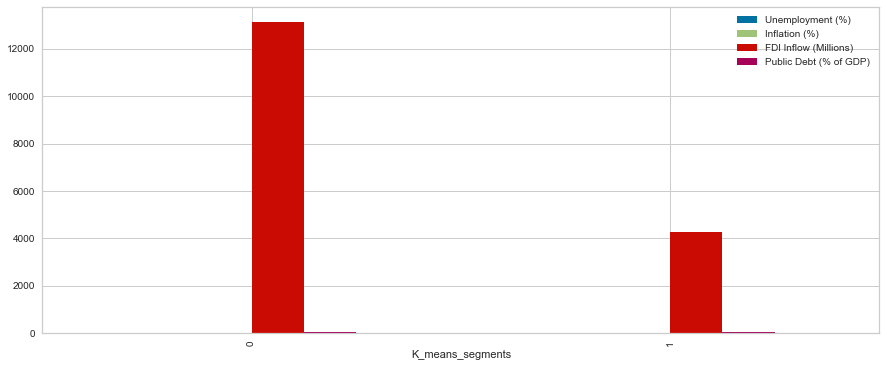

In [197]:
df.groupby("K_means_segments").mean()[num_col[24:]].plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='HC_Clusters'>

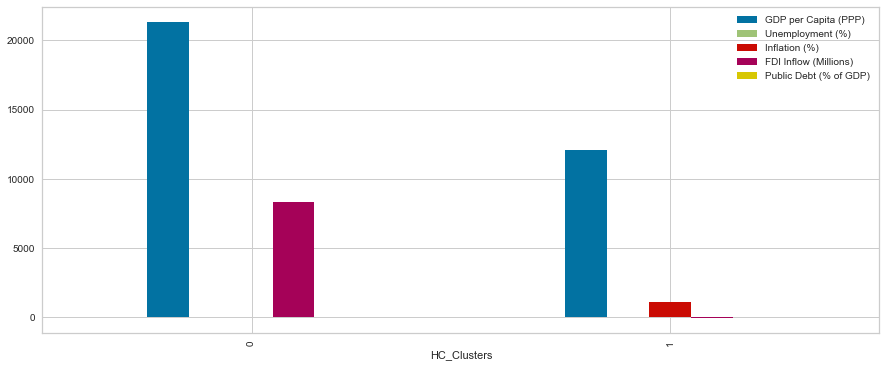

In [201]:
df.groupby("HC_Clusters").mean()[num_col[24:]].plot.bar(figsize=(15, 6))

...and GDP per capita and FDI inflow

It looks like one group is significantly better off in terms of social and ethical issues, but also in financial situation than the other group.

We may be seeing the distinction between first world, who are richer and have better governments, and second world countries.